In [3]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import plotly.express as px
import shap
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import awswrangler as wr
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
)
from catboost.utils import select_threshold
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification,
)
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm

In [4]:

wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
    path=f"s3://multilabel_df/",
    dataset=True,
)
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
]
allInputFeature = caseFeatures + allVisionFeatures
targetCol = [
    x for x in multilabelDf.columns if x not in allInputFeature and x != "CaseID"
]
saloonPredDf = pd.read_csv("/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/saloon_focal_480_aug_2/Saloon - 4 Dr_imgs_pred_output.csv")
# hatchBackDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/hatchback_v2/Hatchback - 5 Dr_imgs_pred_output.csv")
# suvDf = pd.read_csv("/home/alextay96/Desktop/new_workspace/DLDataPipeline/data/results/suv_v2/SUV - 5 Dr_imgs_pred_output.csv")

# imgPredOutput = pd.concat([saloonPredDf, hatchBackDf, suvDf])
imgPredOutput = saloonPredDf
allPredModel = []
allPreds = []
allGt = []
realTestDataDf = multilabelDf[caseFeatures + targetCol + ["CaseID"]].merge(imgPredOutput, on="CaseID")
realTestDataDf = realTestDataDf.loc[:, ~realTestDataDf.columns.str.contains('^Unnamed')]
trainDf = multilabelDf[~multilabelDf["CaseID"].isin(realTestDataDf["CaseID"].unique().tolist())]
assert set(realTestDataDf['CaseID'].tolist()).isdisjoint(trainDf['CaseID'].tolist())

for part in tqdm(targetCol):
    allCaseIdByPart = []
    allPredByPart = []
    allGtByPart = []
    trainCaseId = trainDf["CaseID"].tolist()
    testCaseId = realTestDataDf["CaseID"].tolist()
    X_train = trainDf[allInputFeature]
    Y_train = trainDf[part].to_frame()
    X_test = realTestDataDf[allInputFeature]
    Y_test = realTestDataDf[part].to_frame()
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    neg_count = len(Y_test[Y_test[part] == 0]) / len(Y_test)
    pos_weight = neg_count / pos_count
    print(f"Pos Weight : {pos_weight}")
    train_pool = Pool(
        X_train, Y_train, cat_features=caseFeatures + allVisionFeatures
    )
    test_pool = Pool(X_test, Y_test, cat_features=caseFeatures + allVisionFeatures)
    clf = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="F1",
        iterations=100,
        task_type="GPU",
        # scale_pos_weight=pos_weight,
        use_best_model=True
        # auto_class_weights="Balanced"
        # class_names=["not_dmg", "dmg"],
    )
    clf.fit(
        train_pool, eval_set=test_pool, metric_period=20, plot=False, verbose=0
    )
    test_predict = clf.predict(X_test)
    acc = accuracy_score(Y_test.values.astype(np.int64), test_predict)
    confMat = confusion_matrix(Y_test.values.astype(np.int64), test_predict)
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    tn = confMat[0][0]
    tp = confMat[1][1]
    fp = confMat[0][1]
    fn = confMat[1][0]
    totalSample = fp + fn + tp + tn
    acc = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    assert (tp / (tp + fn)) + (fn / (tp + fn)) == (tn / (tn + fp)) + (
        fp / (tn + fp)
    ) 
    

    allPredModel.append(
        { 
            "part": part,
            "tp": tp / (tp + fn),
            "tn": tn / (tn + fp),
            "fp": fp / (tn + fp),
            "fn": fn / (tp + fn),
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": (2 * precision * recall) / (precision + recall),
            "pos_count": pos_count,
        }
    )
    assert len(testCaseId) == len(test_predict)
    assert len(testCaseId) == len(Y_test)

    allPreds.append({
    "CaseID": testCaseId,
    part : test_predict})
    allGt.append({
    "CaseID": testCaseId,
    part : Y_test.values.squeeze(1)})
 

evalMetrics = pd.json_normalize(allPredModel)
avgPrecision = evalMetrics["precision"].mean()
avgRecall = evalMetrics["recall"].mean()
avgF1 = evalMetrics["f1"].mean()
avgTp = evalMetrics["tp"].mean()
avgTn = evalMetrics["tn"].mean()
avgAcc = evalMetrics["acc"].mean()
avgFn = evalMetrics["fn"].mean()

print(f"Avg Precision : {avgPrecision}")
print(f"Avg Recall : {avgRecall}")
print(f"Avg F1 : {avgF1}")
print(f"Avg TP : {avgTp}")
print(f"Avg TN : {avgTn}")
print(f"Avg FN : {avgFn}")

print(f"avgAcc : {avgAcc}")

  0%|          | 0/34 [00:00<?, ?it/s]

Pos Weight : 1.9594554601953242


  3%|▎         | 1/34 [00:03<01:40,  3.06s/it]

Pos Weight : 0.5302218821729151


  6%|▌         | 2/34 [00:05<01:25,  2.68s/it]

Pos Weight : 1.631578947368421


  9%|▉         | 3/34 [00:07<01:19,  2.56s/it]

Pos Weight : 6.225433526011561


 12%|█▏        | 4/34 [00:10<01:15,  2.52s/it]

Pos Weight : 1.3741690408357075


 15%|█▍        | 5/34 [00:12<01:12,  2.49s/it]

Pos Weight : 1.3900573613766731


 18%|█▊        | 6/34 [00:15<01:09,  2.48s/it]

Pos Weight : 10.848341232227487


 21%|██        | 7/34 [00:17<01:06,  2.46s/it]

Pos Weight : 10.402508551881414


 24%|██▎       | 8/34 [00:20<01:04,  2.47s/it]

Pos Weight : 2.7750094375235936


 26%|██▋       | 9/34 [00:22<01:01,  2.46s/it]

Pos Weight : 5.447453255963895


 29%|██▉       | 10/34 [00:25<00:59,  2.47s/it]

Pos Weight : 2.1605562579013906


 32%|███▏      | 11/34 [00:27<00:56,  2.46s/it]

Pos Weight : 1.3696682464454977


 35%|███▌      | 12/34 [00:29<00:54,  2.46s/it]

Pos Weight : 1.6532236667551075


 38%|███▊      | 13/34 [00:32<00:51,  2.46s/it]

Pos Weight : 2.1665611146295123


 41%|████      | 14/34 [00:34<00:49,  2.46s/it]

Pos Weight : 11.5


 44%|████▍     | 15/34 [00:37<00:46,  2.46s/it]

Pos Weight : 2.806623524933384


 47%|████▋     | 16/34 [00:39<00:45,  2.51s/it]

Pos Weight : 4.109862033725089


 50%|█████     | 17/34 [00:42<00:42,  2.49s/it]

Pos Weight : 6.062146892655368


 53%|█████▎    | 18/34 [00:45<00:40,  2.53s/it]

Pos Weight : 3.5207956600361663


 56%|█████▌    | 19/34 [00:47<00:38,  2.55s/it]

Pos Weight : 3.3084877208099956


 59%|█████▉    | 20/34 [00:50<00:35,  2.53s/it]

Pos Weight : 17.93939393939394


 62%|██████▏   | 21/34 [00:52<00:32,  2.51s/it]

Pos Weight : 17.79699248120301


 65%|██████▍   | 22/34 [00:55<00:30,  2.55s/it]

Pos Weight : 10.534025374855824


 68%|██████▊   | 23/34 [00:57<00:27,  2.52s/it]

Pos Weight : 5.784260515603799


 71%|███████   | 24/34 [01:00<00:25,  2.51s/it]

Pos Weight : 9.695187165775401


 74%|███████▎  | 25/34 [01:02<00:22,  2.49s/it]

Pos Weight : 5.472491909385114


 76%|███████▋  | 26/34 [01:05<00:20,  2.56s/it]

Pos Weight : 8.033423667570009


 79%|███████▉  | 27/34 [01:08<00:18,  2.60s/it]

Pos Weight : 5.013229104028864


 82%|████████▏ | 28/34 [01:10<00:15,  2.55s/it]

Pos Weight : 4.636978579481398


 85%|████████▌ | 29/34 [01:12<00:12,  2.53s/it]

Pos Weight : 14.576323987538942


 88%|████████▊ | 30/34 [01:15<00:10,  2.55s/it]

Pos Weight : 13.705882352941176


 91%|█████████ | 31/34 [01:18<00:07,  2.59s/it]

Pos Weight : 23.813895781637715


 94%|█████████▍| 32/34 [01:20<00:05,  2.55s/it]

Pos Weight : 14.4320987654321


 97%|█████████▋| 33/34 [01:23<00:02,  2.61s/it]

Pos Weight : 26.932960893854748


100%|██████████| 34/34 [01:25<00:00,  2.53s/it]

Avg Precision : 0.4743016295784732
Avg Recall : 0.7296725255178339
Avg F1 : 0.5460659026492023
Avg TP : 0.7296725255178339
Avg TN : 0.7853241267090748
Avg FN : 0.2703274744821661
avgAcc : 0.7947529411764706


In [5]:
fig = px.bar(evalMetrics, x = 'part', y = 'tp')

fig.add_hline(y=avgTp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [6]:
fig = px.bar(evalMetrics, x = 'part', y = 'tn')

fig.add_hline(y=avgTn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [7]:
fig = px.bar(evalMetrics, x = 'part', y = 'acc')

fig.add_hline(y=avgAcc, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgAcc, 2), 0.2, 0.5, 0.7],
    )
)

In [8]:
fig = px.bar(evalMetrics, x = 'part', y = 'precision')

fig.add_hline(y=avgPrecision, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgPrecision, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [9]:
fig = px.bar(evalMetrics, x = 'part', y = 'recall')

fig.add_hline(y=avgRecall, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgRecall, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [10]:
fig = px.bar(evalMetrics, x = 'part', y = 'f1')

fig.add_hline(y=avgF1, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgF1, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [11]:
multilabelPred = pd.DataFrame(pd.DataFrame(allPreds[0]))
for p in tqdm(allPreds[1:]):
    dfPart = pd.DataFrame(p)
    multilabelPred = multilabelPred.merge(dfPart, on="CaseID")
multilabelPred.sort_values(by="CaseID", inplace=True)
multilabelPred

100%|██████████| 33/33 [00:00<00:00, 53.50it/s]


,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,1,1,1,1,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,1
7515,10000084,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
5991,10000104,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,10000181,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
392,10000193,1,1,1,1,1,1,0,1,1,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,13071067,0,1,1,1,0,1,0,0,1,...,0,1,0,1,1,0,0,0,0,1
389,13072671,1,1,1,1,1,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
6247,13074208,0,1,1,1,1,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
6914,13075282,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
multilabelGt = pd.DataFrame(pd.DataFrame(allGt[0]))
for p in tqdm(allGt[1:]):
    dfPart = pd.DataFrame(p)
    multilabelGt = multilabelGt.merge(dfPart, on="CaseID")
multilabelGt.sort_values(by="CaseID", inplace=True)

100%|██████████| 33/33 [00:00<00:00, 50.79it/s]


In [13]:
multilabelGt = multilabelGt[multilabelPred.columns]
multilabelGt

,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
390,10000038,1,1,1,0,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,0
7515,10000084,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
5991,10000104,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,10000181,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
392,10000193,1,1,1,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,13071067,0,1,1,0,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
389,13072671,1,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6247,13074208,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6914,13075282,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list), acc_list

In [15]:
subsetAcc2, acc_list = hamming_score(multilabelGt[targetCol].values, multilabelPred[targetCol].values)
subsetAcc2

0.7188184458510514

In [16]:
evalData = pd.DataFrame(
    [
        {
            "metric" : "subset_accuracy",
            "value" : subsetAcc2

        },
         {
            "metric" : "avg_tpr",
            "value" : avgTp

        },
        {
            "metric" : "avg_tnr",
            "value" : avgTn

        },
        {
            "metric" : "part_recall",
            "value" : avgRecall

        },
            {
            "metric" : "part_precision",
            "value" : avgPrecision

        },
                {
            "metric" : "part_accuracy",
            "value" : avgAcc

        }
    ]
)


In [17]:
fig = px.bar(evalData, x = 'metric', y = 'value', text_auto=True)
fig

In [18]:
targetCol[-1]

'windscreen_rear'

In [19]:
clf.classes_

array([0, 1])

/home/alextay96/anaconda3/envs/work/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



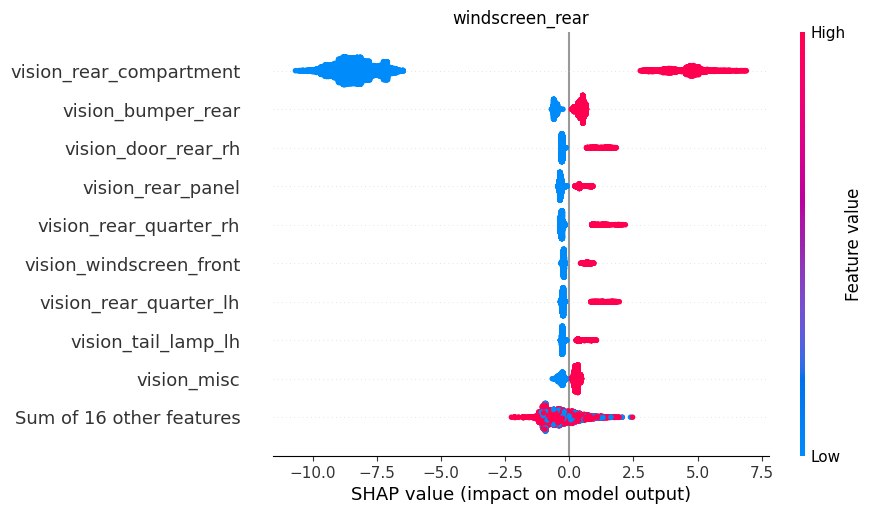

In [20]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
plt.title("windscreen_rear")
shap.plots.beeswarm(shap_values)


In [21]:
caseStudyPred = multilabelPred.sample(n=30).head(30)
caseStudyGt = multilabelGt[multilabelGt["CaseID"].isin(caseStudyPred["CaseID"].unique().tolist())]
caseStudyPred.to_csv("case_study_pred.csv")
caseStudyGt.to_csv("case_study_gt.csv")